In [2]:
Packages <- c("dplyr","broom","cubature", "geosphere", "data.table",  "ggplot2", "bbmle", "dplyr","tidyr", "stringr", "tidyverse", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R") #integrate_kernel_sum0.5
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve.R") #median
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve90.R") #dist 90% retained
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernPDF.R")


In [3]:
SimPlusGenFits <- read.csv(file="~/oceanography/script_output/KernelFits/SimPlusGenKernelFits.csv", header=T, stringsAsFactors = F)
CombinedSims <- read.csv(file="~/oceanography/script_output/KernelFits/CombinedSimulationKernelFits.csv", header=T, stringsAsFactors = F) %>% 
    gather(2:6, key="metric", value="value") %>% 
    mutate(DataType="Sim") %>%
    rename(Year="year")

In [36]:
#make a df with the pdf values at each distance to plot for each kernel fit
#get all the case k and theta averages to plot
FitsToPlot <- SimPlusGenFits %>% 
    filter(metric %in% c("k", "theta") ) %>%
    filter(Stat=="Mean" | Stat=="MLE") %>%
   mutate(Adj=ifelse(is.na(Adj), "no", Adj)) #change the NAs to no for the genetic

SimCasesToPlot <- FitsToPlot %>% 
     distinct(Year, Adj, DataType)

#distances to plot
distances <- data.frame(dist=seq(0, 60, 0.1))

SimCasesToPlot$distance <- NA
SimCasesToPlot$dispersal <- NA


SimToPlot <- SimCasesToPlot[FALSE,]

#make a long form df for each combo to plot

for(i in 1:nrow(SimCasesToPlot)){
    
    case_eval <- SimCasesToPlot[i,] #select row by position, each row represents the average fit for a given year and case combination
    
    k_eval <- as.numeric(FitsToPlot %>% #pull out the avg value of k that matches the year/case
        ungroup() %>%
        filter(Year==case_eval$Year & Adj==case_eval$Adj & DataType==case_eval$DataType & metric=="k") %>%
        select(value))
    
    theta_eval <- as.numeric(FitsToPlot %>% #pull out the avg value of theta that matches the year/case
        ungroup() %>%
        filter(Year==case_eval$Year & Adj==case_eval$Adj & DataType==case_eval$DataType & metric=="theta") %>%
        select(value))
    
    case_eval_build <- case_eval[FALSE,] #this will become the df with pdf at each distance for a given year/case combo

    for(j in 1:nrow(distances)){ #go through each distance and compute the pdf value. append the original df so that there's a row for each year/case/distance combination
        
        case_eval_beta <- case_eval
        
        dist_eval <- distances[j,]
        case_eval_beta$distance <- dist_eval
        case_eval_beta$dispersal <- predicted_disp(k=k_eval, theta=theta_eval, d=dist_eval)
        
        case_eval_build <- bind_rows(case_eval_build, case_eval_beta)
    
    }
    
        SimToPlot <- bind_rows(SimToPlot, case_eval_build) #add to the larger df that will eventually have all year/case/dist/pdf combos

}


In [37]:
head(SimToPlot %>% filter(DataType=="Gen"))
#(FitsToPlot)

Year,Adj,DataType,distance,dispersal
2012,no,Gen,0.0,0.09556381
2012,no,Gen,0.1,0.09478249
2012,no,Gen,0.2,0.09397513
2012,no,Gen,0.3,0.09316204
2012,no,Gen,0.4,0.09234778
2012,no,Gen,0.5,0.09153451


In [ ]:
#make plots for each case

Warning message:
“Removed 328 row(s) containing missing values (geom_path).”Warning message:
“Removed 84 row(s) containing missing values (geom_path).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 328 row(s) containing missing values (geom_path).”Warning message:
“Removed 84 row(s) containing missing values (geom_path).”

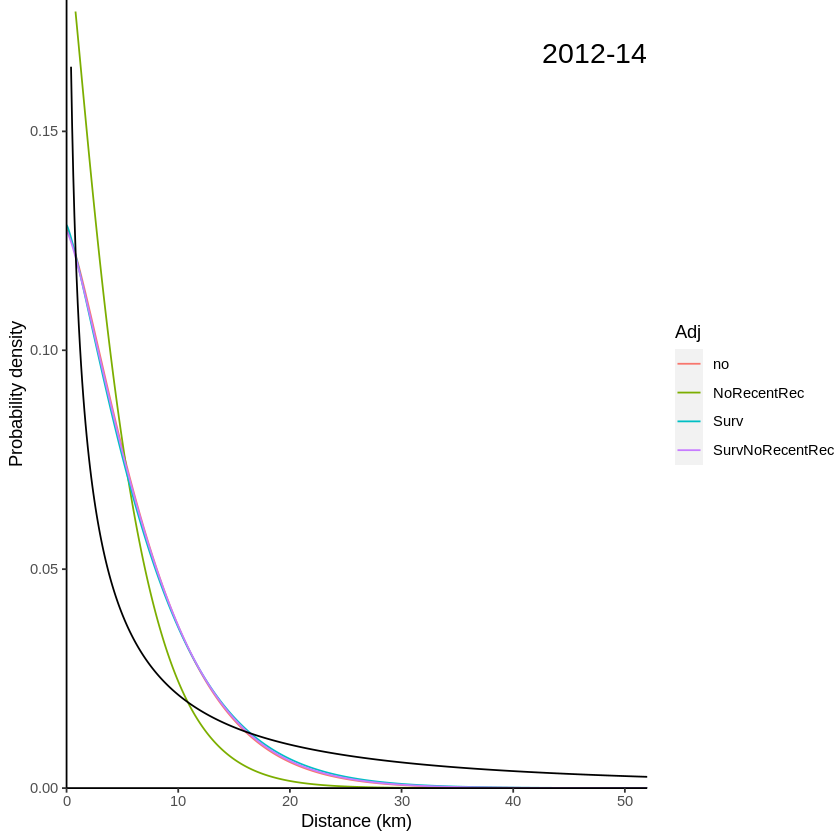

In [45]:
CaseKernels2012_14 <- ggplot(data= (SimToPlot %>% filter(Year=="2012-14" & DataType=="Sim")), aes(x=distance, y=dispersal, color=Adj))+ 
    geom_line()+ #data=to_plot_df2, aes(x=dist, y=pdf, group=iter), color="gray60", size=.2, alpha=0.2
    geom_line(data=(SimToPlot %>% filter(Year=="2012-14" & DataType=="Gen")), aes(x=distance, y=dispersal), color="black") +
    #geom_area(data=kernel15, aes(x=dist, y=norm_pdf, fill=as.factor(median)), alpha=0.1)+
    annotate("text", x =Inf, y = 0.17, vjust=1, hjust=1, label = "2012-14", size=6)+#8 for publication, 15 for presentation, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##annotate("text", x =MDD15, y = 0.01, vjust=1, hjust=1, label = "mu", color="deepskyblue2", size=15, family="Helvetica", parse=T)+#, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##scale_fill_manual(values= c("whitesmoke", "cadetblue3")) +
    ##scale_color_manual(values= c("whitesmoke", "cadetblue3")) +
    #geom_line(color="black", size=.6) +  
    ##geom_vline(xintercept = MDD15, linetype="dotted", color = "deepskyblue2", size=1) +
    theme(#axis.title.y=element_blank(),
    #axis.title.x=element_blank(),
    #plot.background = element_rect(colour = "black", size = 1),
    #axis.text.x =  element_text(size=15, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    #axis.text.y =  element_blank(), #element_text(size=15, color="black", family="Helvetica"), 
    panel.grid.major = element_blank(),
    plot.margin=unit(c(0,0,0.2,0.2),"cm"),#,
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Distance (km)") + #
    ylab("Probability density") + 
    #guides(fill=FALSE)+
    scale_x_continuous(limits = c(0,52), expand = c(0, 0), breaks=c(seq(0, 50, 10))) +
    scale_y_continuous(expand = c(0,0), limits = c(0,.18)) 


CaseKernels2012_14
#ggsave(filename="SimulationCaseKernelFits2012-14.png", plot= CaseKernels2012_14, path="~/oceanography/script_output/KernelFits/Plots/" )


In [23]:
FitsToPlot <- CombinedSims %>% 
    filter(metric %in% c("k", "theta") ) %>%
    #filter(St)
    select(-DataType)
head(FitsToPlot)

Year,iteration,Adj,metric,value
2012,1,no,k,-2.8047543
2012,2,no,k,-2.8511524
2012,3,no,k,-1.5418595
2012,4,no,k,-2.1396522
2012,5,no,k,-2.1590598
2012,6,no,k,-0.8263778


In [53]:
#to plot all ensembles
#make a df with the pdf values at each distance to plot for each kernel fit
#get all the case k and theta averages to plot
CombinedSimsDT <- as.data.table(CombinedSims %>% spread(metric, value) %>% select(-dist90, -mdd, -med))

FitsToPlot <- CombinedSims %>% 
    filter(metric %in% c("k", "theta") ) %>%
    #filter(St)
    select(-DataType)

SimCasesToPlot <- as.data.table(FitsToPlot %>% 
        spread(metric, value) %>%
        #select(-iteration) %>%
        distinct(Year, Adj, .keep_all = T))

#distances to plot
distances <- seq(0, 60, .1) #these are the distances to iterate over

full_res <- data.table(Year=character(), Adj=character(), iteration=numeric(), distance=numeric(), dispersal=numeric()) #this will hold all of those year/adj/iterationcombinations
year_adj_res <- data.table(Year=character(), Adj=character(), iteration=numeric(), distance=numeric(), dispersal=numeric()) #this will hold results for every iteration in a year/case combo

#SimToPlot <- SimCasesToPlot[FALSE,]

#make a long form df for each combo to plot
pb <- txtProgressBar(min = 0, max = nrow(SimCasesToPlot), style = 3)
start_time <- Sys.time()

for(i in 1:nrow(SimCasesToPlot)){
    
    case_eval <- SimCasesToPlot[i,] #select row by position, each row represents the average fit for a given year and case combination

    sampled_iterations <- sample.int(1000, 100, replace=F) #make a vector of iterations out of the full 1000 to sample for plotting

    iteration_res <- data.table(Year=character(), Adj=character(), iteration=numeric(), distance=numeric(), dispersal=numeric()) [1:length(distances)]#this will hold results for each iteration pdf at each distance

 for(k in 1:length(sampled_iterations )){ 
     
         iteration_eval <- sampled_iterations[k] 

         k_eval <- CombinedSimsDT[CombinedSimsDT$iteration==iteration_eval & CombinedSimsDT$Year==case_eval$Year & CombinedSimsDT$Adj==case_eval$Adj, k] #pull a row to get the theta/k values for that iteration
     
         theta_eval <- CombinedSimsDT[CombinedSimsDT$iteration==iteration_eval & CombinedSimsDT$Year==case_eval$Year & CombinedSimsDT$Adj==case_eval$Adj, theta] 
         

         iteration_res$distance <- distances #before starting the loop, plug in the vector with distances as column values and the year/adj identifying information, that doesn't need to be done every time within the loop just once outside
         iteration_res$Year <- case_eval$Year
         iteration_res$Adj <- case_eval$Adj
         iteration_res$iteration <- iteration_eval
     #for(j in 1:length(distances)){ #go through each distance and compute the pdf value. append the original df so that there's a row for each year/case/distance combination
   
   
   iteration_res$dispersal <-  exp(k_eval) * theta_eval * exp(-(exp(k_eval) * distances)^theta_eval)/gamma(1/theta_eval) #perform the pdf calculation operation on the whole distance vector once
   
   year_adj_res <- rbind(year_adj_res, iteration_res) #add in the results for a given iteration to a table specific to the year/adj combination

   }
      
#full_res <- rbind(full_res, year_adj_res) #add in the table for all sampled iteration pdfs across selected distances for each year/adj combo to a table for every year/adj combo
    setTxtProgressBar(pb, i)
} 

end_time <- Sys.time()
end_time-start_time   
#write.csv(year_adj_res, file="~/oceanography/script_output/KernelFits/Plots/SampledKernelsForPlotting.csv", row.names=F)




  |======================================================================| 100%

Time difference of 34.43244 secs

In [54]:
#write.csv(year_adj_res, file="~/oceanography/script_output/KernelFits/Plots/SampledKernelsForPlotting.csv", row.names=F)
#year_adj_res <- read.csv( file="~/oceanography/script_output/KernelFits/Plots/SampledKernelsForPlotting.csv", header=T)


In [55]:
#add adj variables for genetics so that can appear in all facets
testSurv <-(SimToPlot %>% filter(DataType=="Gen")) %>%
    mutate(Adj="Surv")

testSurvNoRecentRec <-(SimToPlot %>% filter(DataType=="Gen")) %>%
    mutate(Adj="SurvNoRecentRec")

testNoRecentRec <-(SimToPlot %>% filter(DataType=="Gen")) %>%
    mutate(Adj="NoRecentRec")

testForPlots <- bind_rows(SimToPlot, testSurv, testSurvNoRecentRec, testNoRecentRec)

Warning message:
“Removed 28257 row(s) containing missing values (geom_path).”Warning message:
“Removed 84 row(s) containing missing values (geom_path).”Warning message:
“Removed 80 row(s) containing missing values (geom_path).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 28257 row(s) containing missing values (geom_path).”Warning message:
“Removed 84 row(s) containing missing values (geom_path).”Warning message:
“Removed 80 row(s) containing missing values (geom_path).”

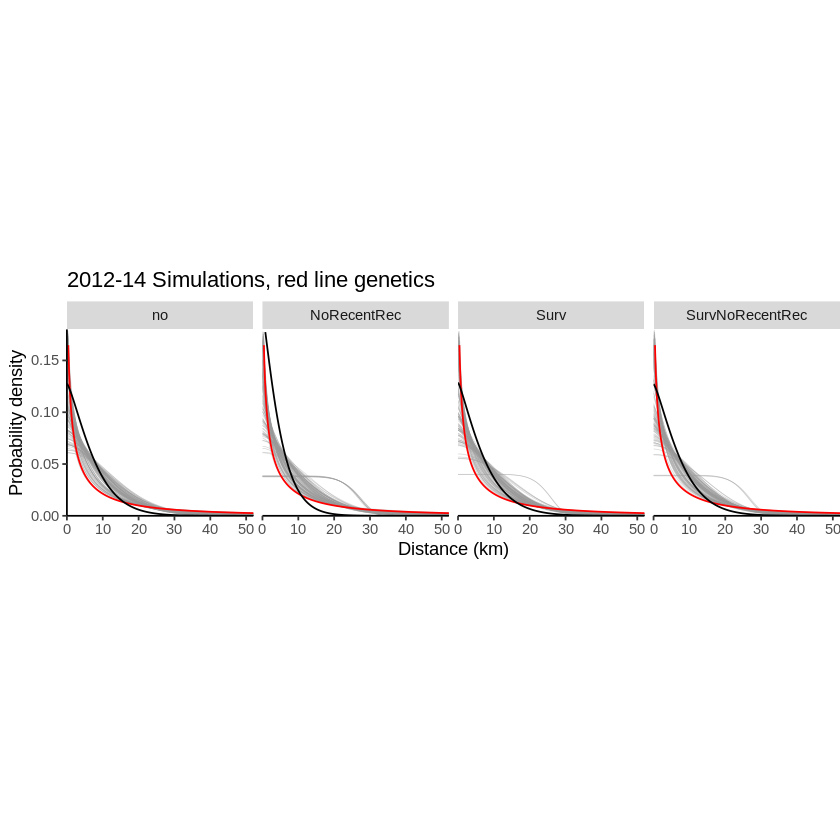

In [60]:
EnsemblesToPlot <- as.data.frame(year_adj_res) %>%
    group_by(iteration)

test <- ggplot(data= (EnsemblesToPlot %>% filter(Year=="2012-14")), aes(x=distance, y=dispersal))+ 
    geom_line(data= (EnsemblesToPlot %>% filter(Year=="2012-14")), aes(x=distance, y=dispersal, group=iteration),color="gray60", size=.2, alpha=0.4)+
    geom_line(data=(testForPlots %>% filter(Year=="2012-14" & DataType=="Gen")), aes(x=distance, y=dispersal), color="red") +
    geom_line(data=(SimToPlot %>% filter(Year=="2012-14" & DataType=="Sim")), aes(x=distance, y=dispersal), color="black") +
    #geom_area(data=kernel15, aes(x=dist, y=norm_pdf, fill=as.factor(median)), alpha=0.1)+
    #annotate("text", x =Inf, y = 0.17, vjust=1, hjust=1, label = "2012-14", size=6)+#8 for publication, 15 for presentation, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##annotate("text", x =MDD15, y = 0.01, vjust=1, hjust=1, label = "mu", color="deepskyblue2", size=15, family="Helvetica", parse=T)+#, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##scale_fill_manual(values= c("whitesmoke", "cadetblue3")) +
    ##scale_color_manual(values= c("whitesmoke", "cadetblue3")) +
    #geom_line(color="black", size=.6) +  
    ##geom_vline(xintercept = MDD15, linetype="dotted", color = "deepskyblue2", size=1) +
    theme(#axis.title.y=element_blank(),
    #axis.title.x=element_blank(),
    #plot.background = element_rect(colour = "black", size = 1),
    #axis.text.x =  element_text(size=15, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    #axis.text.y =  element_blank(), #element_text(size=15, color="black", family="Helvetica"), 
    panel.grid.major = element_blank(),
    plot.margin=unit(c(0,0,0.2,0.2),"cm"),#,
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Distance (km)") + #
    ylab("Probability density") + 
    #guides(fill=FALSE)+
    scale_x_continuous(limits = c(0,52), expand = c(0, 0), breaks=c(seq(0, 50, 10))) +
    scale_y_continuous(expand = c(0,0), limits = c(0,.18)) 
Facet2012_14 <- test + facet_grid(.~Adj) +
  theme(aspect.ratio = 1) + ggtitle("2012-14 Simulations, red line genetics")
Facet2012_14

#ggsave(filename="SimulationCaseKernelEnsembles2012-14.png", plot= Facet2012_14, path="~/oceanography/script_output/KernelFits/Plots/" )
